In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


In [14]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')


In [15]:
print('This images is:' , type(image), 'with dimensions:', image.shape)

This images is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


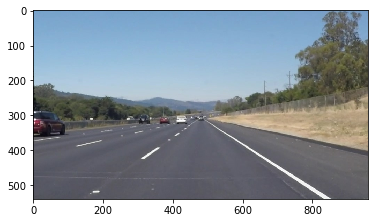

In [16]:
plt.imshow(image)

In [17]:
import os


In [18]:
image


array([[[179, 196, 212],
        [140, 161, 178],
        [132, 156, 180],
        ...,
        [133, 155, 178],
        [144, 159, 180],
        [183, 196, 213]],

       [[140, 161, 180],
        [143, 165, 186],
        [133, 161, 185],
        ...,
        [135, 159, 185],
        [141, 159, 181],
        [145, 162, 180]],

       [[131, 157, 180],
        [133, 161, 185],
        [126, 160, 187],
        ...,
        [129, 156, 185],
        [134, 158, 184],
        [131, 153, 176]],

       ...,

       [[120, 121, 126],
        [ 91,  92,  97],
        [ 83,  84,  89],
        ...,
        [ 88,  89,  93],
        [ 94,  95,  99],
        [120, 121, 125]],

       [[138, 139, 143],
        [105, 106, 110],
        [ 89,  90,  95],
        ...,
        [ 97,  98, 100],
        [109, 110, 112],
        [139, 140, 142]],

       [[180, 181, 185],
        [140, 141, 145],
        [117, 118, 123],
        ...,
        [122, 123, 125],
        [140, 141, 143],
        [179, 180, 182]]

In [19]:
files = os.listdir("test_images/")


In [20]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=12):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # initialize lists to hold line formula values
    bLeftValues     = []  # b of left lines
    bRightValues    = []  # b of Right lines
    mPositiveValues = []  # m of Left lines
    mNegitiveValues = []  # m of Right lines
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
            # calculate slope and intercept
            m = (y2-y1)/(x2-x1)
            b = y1 - x1*m
            
            # threshold to check for outliers
            if m >= 0 and (m < 0.2 or m > 0.8):
                continue
            elif m < 0 and (m < -0.8 or m > -0.2):
                continue
                
            # seperate positive line and negative line slopes
            if m > 0:
                mPositiveValues.append(m)
                bLeftValues.append(b)
            else:
                mNegitiveValues.append(m)
                bRightValues.append(b)
    
    # Get image shape and define y region of interest value
    imshape = img.shape
    y_max   = imshape[0] # lines initial point at bottom of image    
    y_min   = 330        # lines end point at top of ROI

    # Get the mean of all the lines values
    AvgPositiveM = mean(mPositiveValues)
    AvgNegitiveM = mean(mNegitiveValues)
    AvgLeftB     = mean(bLeftValues)
    AvgRightB    = mean(bRightValues)

    # use average slopes to generate line using ROI endpoints
    if AvgPositiveM != 0:
        x1_Left = (y_max - AvgLeftB)/AvgPositiveM
        y1_Left = y_max
        x2_Left = (y_min - AvgLeftB)/AvgPositiveM
        y2_Left = y_min
    if AvgNegitiveM != 0:
        x1_Right = (y_max - AvgRightB)/AvgNegitiveM
        y1_Right = y_max
        x2_Right = (y_min - AvgRightB)/AvgNegitiveM
        y2_Right = y_min

        # define average left and right lines
        cv2.line(img, (int(x1_Left), int(y1_Left)), (int(x2_Left), int(y2_Left)), color, thickness) #avg Left Line
        cv2.line(img, (int(x1_Right), int(y1_Right)), (int(x2_Right), int(y2_Right)), color, thickness) #avg Right Line
           
def mean(list):
    """
    calculate mean of list
    """
    return float(sum(list)) / max(len(list), 1)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [21]:
def process_image(imgName):
    # Get image
    image = mpimg.imread('test_images/'+imgName)
    
    # Create gray image
    grayImg = grayscale(image)
    
    # Gaussian smoothing / blurring
    gblur = gaussian_blur(grayImg, 5)
    
    # Get Canny Img
    edges = canny(gblur, 50, 150)
    
    # Mask surroundings
    imgShape = image.shape
    polygon = np.array([ [(50, imgShape[0]), (460, 310), (490, 310), (imgShape[1]-50, imgShape[0]) ] ], dtype=np.int32)
    roi = region_of_interest(edges, polygon)
    
    # Hough Lines (img, rho, theta, threshold, min_line_len, max_line_gap)
    hLines = hough_lines(roi, 1, np.pi/180, 22, 18, 1)
    
    # Draw lines on edge image
    imgWithLines = weighted_img(hLines,image)
    
    plt.imshow(imgWithLines)
    return imgWithLines


Processing  solidWhiteCurve.jpg 


Processing  solidWhiteRight.jpg 


Processing  solidYellowCurve.jpg 


Processing  solidYellowCurve2.jpg 


Processing  solidYellowLeft.jpg 


Processing  whiteCarLaneSwitch.jpg 



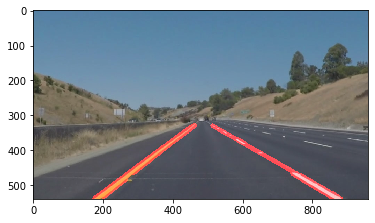

In [23]:
for file in files:
    print("\nProcessing ",file,"\n")
    pImage = process_image(file)
    mpimg.imsave("output_images/"+file[:-4]+"processed.png", pImage)

TypeError: Image data of dtype <U22 cannot be converted to float

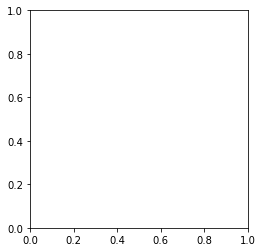